<br><br>

<font color=#191347 ><font>
<p style = "font-family:times;">
    <font size="7">
        Interactive Learning 
    </font>    
</p>

<br>
    
<font color=#ed1c24><font>
<p style = "font-family:optima;">
    <font size="6">
        Homework #5
    </font>    
<font color=#000000> <font>
</p>

> $\textit{Mohammad Saadati - 810198410}$

# Table of Contents

- [Packages](#0)
- [Part 1](#1)
    - [States, Actions, Reward](#1-1)
    - [Continuous & Discrete](#1-2)
- [Part 2](#2)
    - [Deep Q-Learning](#2-1)
    - [Reward](#2-2)
    - [Render](#2-3)
    - [Hyperparameters](#2-4)
- [Part 3](#3)
    - [Result](#3-1)
- [Part 4](#4)
    - [DQN with Prioritized Replay Buffer](#4-1)
    - [Reward](#4-2)

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [ ]:
! pip install gym
! pip install highway-env
import gym
import highway_env

import time
import random
from collections import namedtuple, deque
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
from tensorflow.keras import *
from tensorflow.keras.utils import *
from copy import deepcopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 29.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 46.2 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827649 sha256=f3b13335244be72b23b1e3a0c41cc80f1a2b81878295ffc189faec1336c5729f
  Stored in directory: /root/.cache/pip/wheels/17/79/65/7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [ ]:
# !pip install pygame 

# import os
# os.environ['SDL_VIDEODRIVER']='dummy'
# import pygame
# pygame.display.set_mode((640,480))

<a name='1'></a>
# Part 1

In [ ]:
env = gym.make("highway-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state_size, action_size 

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


(5, 5)

<a name='1-1'></a>
## States, Actions, Reward

In [ ]:
env.reset()

(array([[ 1.        ,  0.91337574,  0.75      ,  0.3125    ,  0.        ],
        [ 1.        ,  0.11083002, -0.25      , -0.01942983,  0.        ],
        [ 1.        ,  0.21481097, -0.5       , -0.04137274,  0.        ],
        [ 1.        ,  0.32364187, -0.75      , -0.02599965,  0.        ],
        [ 1.        ,  0.42045397, -0.75      , -0.02693709,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 1,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 1.0,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

In [ ]:
action = env.action_type.actions_indexes["IDLE"]
obs, reward, done, truncated, info = env.step(action)

In [ ]:
obs 

array([[ 1.        ,  1.        ,  0.75      ,  0.3125    ,  0.        ],
       [ 1.        ,  0.10173588, -0.25      , -0.0259383 ,  0.        ],
       [ 1.        ,  0.19605842, -0.5       , -0.05235818,  0.        ],
       [ 1.        ,  0.29961362, -0.75      , -0.09200355,  0.        ],
       [ 1.        ,  0.40786678, -0.75      , -0.03602759,  0.        ]],
      dtype=float32)

In [ ]:
reward

0.8666666666666667

In [ ]:
done

False

In [ ]:
truncated

False

In [ ]:
info

{'speed': 25.0,
 'crashed': False,
 'action': 1,
 'rewards': {'collision_reward': 0.0,
  'right_lane_reward': 1.0,
  'high_speed_reward': 0.5,
  'on_road_reward': 1.0}}

<a name='1-2'></a>
## Continuous & Discrete

In [ ]:
env.action_space

Discrete(5)

In [ ]:
env.observation_space

Box(-inf, inf, (5, 5), float32)

In [ ]:
env.observation_space.shape[0]

5

<a name='2'></a>
# Part 2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!nvidia-smi

Fri Feb  3 08:13:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a name='2-1'></a>
## Deep Q-Learning

In [ ]:
env = gym.make("merge-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state_size, action_size 

(5, 5)

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ExperienceBuffer():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
        
    def __len__(self):
        return len(self.memory)
    
    def store_transition(self, state, action, next_state, reward, done):
        self.memory.append(Transition(state, action, next_state, reward, done))

    def get_sample(self, batch_size):
        return random.sample(self.memory, batch_size) 

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [ ]:
class DeepQLearning():
    def __init__(self, state_size, action_size, batch_size, gamma=0.99, buffer_size=25000, alpha=1e-4):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.experience_buffer = ExperienceBuffer(buffer_size)
        self.value_network = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.value_network.parameters(), lr=alpha)

    def choose_action(self, state, epsilon=0.0):
        state = torch.from_numpy(state).float().to(device)
        if np.random.rand()<epsilon:
            return torch.tensor([[np.random.randint(self.action_size)]])
        else:
            with torch.no_grad():
                q_value = self.value_network(state)
                return torch.argmax(q_value).view(1, 1) % self.action_size
            
    def get_sample_experiences(self):
        batch = Transition(*zip(*self.experience_buffer.get_sample(self.batch_size)))
        batch_state = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        batch_action = torch.tensor(np.vstack(batch.action)).long().to(device)
        batch_next_state = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        batch_reward = torch.tensor(np.vstack(batch.reward)).float().to(device)
        batch_done = torch.tensor(np.vstack(batch.done)).to(device)
        return batch_state, batch_action, batch_next_state, batch_reward, batch_done
    
    def calculate_q_values(self, batch_state, batch_action, batch_next_state, batch_reward, batch_done):
        q_values = self.value_network(batch_state).gather(1, batch_action)
        next_q_values = self.value_network(batch_next_state).detach().max(1)[0].unsqueeze(1)
        next_q_values = next_q_values[0:len(batch_done)]
        next_q_values[batch_done] = 0.0
        expected_q_values = batch_reward + (self.gamma * next_q_values)
        return q_values, expected_q_values
        
    def compute_loss(self, q_values, expected_q_values):
        loss = F.mse_loss(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def learn(self):
        if len(self.experience_buffer) < self.batch_size:
            return
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = self.get_sample_experiences()
        q_values, expected_q_values = self.calculate_q_values(batch_state, batch_action, batch_next_state, batch_reward, batch_done)
        self.compute_loss(q_values, expected_q_values)    

    def load(self, fname, device):
        self.value_network.load_state_dict(torch.load(fname, map_location=torch.device(device)))

In [ ]:
def run_DeepQLearning_agent(_batch_size, _agent=None, number_of_episodes=250, epsilon_decay_rate=0.97, reps=10):
    epsilon_end = 0.01
    optimal_agent = None
    state_dict = None
    cpp = None

    cumulative_rewards = np.zeros((reps,number_of_episodes))
    for rep in range(reps):
        agent = _agent
        if _agent == None:
            agent = DeepQLearning(state_size, action_size, batch_size=_batch_size)
        epsilon = 1.0
        
        for episode in range(number_of_episodes):
            recent_cumulative_rewards = deque(maxlen=25)
            # obs, info = S = env.reset()
            state,_ = env.reset()
            done = truncated = False
            cumulative_reward = 0
            while not (done or truncated):
                action = agent.choose_action(state, epsilon).item()
                obs, reward, done, truncated, info = env.step(action)
                next_state, reward = obs, reward
                agent.experience_buffer.store_transition(state, action, next_state, reward, done)
                agent.learn()
                state = next_state
                cumulative_reward += reward
            
            cumulative_rewards[rep][episode]=cumulative_reward
            recent_cumulative_rewards.append(cumulative_reward)
            epsilon = max(epsilon_end, epsilon_decay_rate*epsilon)
            print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(episode+1, np.mean(recent_cumulative_rewards), epsilon), end="")
            if (episode+1) % (number_of_episodes/10) == 0:
                print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(episode+1, np.mean(recent_cumulative_rewards), epsilon))

        cpp = 'dqn'+str(_batch_size) +'-checkpoint.pth'
        state_dict = agent.value_network.state_dict()
        torch.save(agent.value_network.state_dict(), cpp)
        optimal_agent = agent

    return cumulative_rewards, agent

<a name='2-2'></a>
## Reward

In [ ]:
crs0, agent0 = run_DeepQLearning_agent(_batch_size=16)

Episode 25	Average Reward: 10.91	Epsilon: 0.47
Episode 50	Average Reward: 10.94	Epsilon: 0.22
Episode 75	Average Reward: 11.67	Epsilon: 0.10
Episode 100	Average Reward: 14.92	Epsilon: 0.05
Episode 125	Average Reward: 11.08	Epsilon: 0.02
Episode 150	Average Reward: 11.08	Epsilon: 0.01
Episode 175	Average Reward: 14.92	Epsilon: 0.01
Episode 200	Average Reward: 14.75	Epsilon: 0.01
Episode 225	Average Reward: 14.14	Epsilon: 0.01
Episode 250	Average Reward: 10.77	Epsilon: 0.01
Episode 25	Average Reward: 9.75	Epsilon: 0.47
Episode 50	Average Reward: 11.08	Epsilon: 0.22
Episode 75	Average Reward: 11.39	Epsilon: 0.10
Episode 100	Average Reward: 10.77	Epsilon: 0.05
Episode 125	Average Reward: 10.94	Epsilon: 0.02
Episode 150	Average Reward: 10.91	Epsilon: 0.01
Episode 175	Average Reward: 10.80	Epsilon: 0.01
Episode 200	Average Reward: 11.08	Epsilon: 0.01
Episode 225	Average Reward: 14.92	Epsilon: 0.01
Episode 250	Average Reward: 14.92	Epsilon: 0.01
Episode 25	Average Reward: 10.83	Epsilon: 0.47


In [ ]:
crs1, agent1 = run_DeepQLearning_agent(_batch_size=32)

Episode 25	Average Reward: 10.97	Epsilon: 0.47
Episode 50	Average Reward: 14.44	Epsilon: 0.22
Episode 75	Average Reward: 12.89	Epsilon: 0.10
Episode 100	Average Reward: 10.75	Epsilon: 0.05
Episode 125	Average Reward: 11.05	Epsilon: 0.02
Episode 150	Average Reward: 10.58	Epsilon: 0.01
Episode 175	Average Reward: 14.25	Epsilon: 0.01
Episode 200	Average Reward: 10.75	Epsilon: 0.01
Episode 225	Average Reward: 11.02	Epsilon: 0.01
Episode 250	Average Reward: 12.86	Epsilon: 0.01
Episode 25	Average Reward: 12.55	Epsilon: 0.47
Episode 50	Average Reward: 11.08	Epsilon: 0.22
Episode 75	Average Reward: 13.19	Epsilon: 0.10
Episode 100	Average Reward: 14.14	Epsilon: 0.05
Episode 125	Average Reward: 14.92	Epsilon: 0.02
Episode 150	Average Reward: 14.97	Epsilon: 0.01
Episode 175	Average Reward: 11.08	Epsilon: 0.01
Episode 200	Average Reward: 14.25	Epsilon: 0.01
Episode 225	Average Reward: 13.08	Epsilon: 0.01
Episode 250	Average Reward: 14.92	Epsilon: 0.01
Episode 25	Average Reward: 14.28	Epsilon: 0.47

In [ ]:
crs2, agent2 = run_DeepQLearning_agent(_batch_size=64)

Episode 25	Average Reward: 11.72	Epsilon: 0.47
Episode 50	Average Reward: 10.78	Epsilon: 0.22
Episode 75	Average Reward: 10.75	Epsilon: 0.10
Episode 100	Average Reward: 11.08	Epsilon: 0.05
Episode 125	Average Reward: 11.08	Epsilon: 0.02
Episode 150	Average Reward: 10.89	Epsilon: 0.01
Episode 175	Average Reward: 11.08	Epsilon: 0.01
Episode 200	Average Reward: 11.89	Epsilon: 0.01
Episode 225	Average Reward: 11.00	Epsilon: 0.01
Episode 250	Average Reward: 11.08	Epsilon: 0.01
Episode 25	Average Reward: 10.72	Epsilon: 0.47
Episode 50	Average Reward: 10.77	Epsilon: 0.22
Episode 75	Average Reward: 14.08	Epsilon: 0.10
Episode 100	Average Reward: 8.78	Epsilon: 0.05
Episode 125	Average Reward: 11.08	Epsilon: 0.02
Episode 150	Average Reward: 10.64	Epsilon: 0.01
Episode 175	Average Reward: 11.08	Epsilon: 0.01
Episode 200	Average Reward: 14.92	Epsilon: 0.01
Episode 225	Average Reward: 11.08	Epsilon: 0.01
Episode 250	Average Reward: 10.31	Epsilon: 0.01
Episode 25	Average Reward: 10.97	Epsilon: 0.47


In [ ]:
 crs3, agent3 = run_DeepQLearning_agent(_batch_size=128)

Episode 25	Average Reward: 10.72	Epsilon: 0.47
Episode 50	Average Reward: 11.08	Epsilon: 0.22
Episode 75	Average Reward: 6.53	Epsilon: 0.10
Episode 100	Average Reward: 13.53	Epsilon: 0.05
Episode 125	Average Reward: 11.02	Epsilon: 0.02
Episode 150	Average Reward: 11.08	Epsilon: 0.01
Episode 175	Average Reward: 14.61	Epsilon: 0.01
Episode 200	Average Reward: 11.41	Epsilon: 0.01
Episode 225	Average Reward: 11.75	Epsilon: 0.01
Episode 250	Average Reward: 14.92	Epsilon: 0.01
Episode 25	Average Reward: 13.33	Epsilon: 0.47
Episode 50	Average Reward: 12.92	Epsilon: 0.22
Episode 75	Average Reward: 11.08	Epsilon: 0.10
Episode 100	Average Reward: 12.97	Epsilon: 0.05
Episode 125	Average Reward: 14.14	Epsilon: 0.02
Episode 150	Average Reward: 14.92	Epsilon: 0.01
Episode 175	Average Reward: 14.14	Epsilon: 0.01
Episode 200	Average Reward: 14.89	Epsilon: 0.01
Episode 225	Average Reward: 12.97	Epsilon: 0.01
Episode 250	Average Reward: 14.92	Epsilon: 0.01
Episode 25	Average Reward: 11.36	Epsilon: 0.47


In [ ]:
 crs34, agent34 = run_DeepQLearning_agent(_batch_size=256)

Episode 25	Average Reward: 13.94	Epsilon: 0.47
Episode 50	Average Reward: 10.86	Epsilon: 0.22
Episode 75	Average Reward: 11.02	Epsilon: 0.10
Episode 100	Average Reward: 11.08	Epsilon: 0.05
Episode 125	Average Reward: 10.64	Epsilon: 0.02
Episode 150	Average Reward: 13.47	Epsilon: 0.01
Episode 175	Average Reward: 11.52	Epsilon: 0.01
Episode 200	Average Reward: 14.92	Epsilon: 0.01
Episode 225	Average Reward: 11.58	Epsilon: 0.01
Episode 250	Average Reward: 14.19	Epsilon: 0.01
Episode 25	Average Reward: 10.72	Epsilon: 0.47
Episode 50	Average Reward: 11.08	Epsilon: 0.22
Episode 75	Average Reward: 10.23	Epsilon: 0.10
Episode 100	Average Reward: 10.73	Epsilon: 0.05
Episode 125	Average Reward: 11.00	Epsilon: 0.02
Episode 150	Average Reward: 10.97	Epsilon: 0.01
Episode 175	Average Reward: 11.08	Epsilon: 0.01
Episode 200	Average Reward: 10.50	Epsilon: 0.01
Episode 225	Average Reward: 10.97	Epsilon: 0.01
Episode 250	Average Reward: 10.80	Epsilon: 0.01
Episode 25	Average Reward: 9.98	Epsilon: 0.47


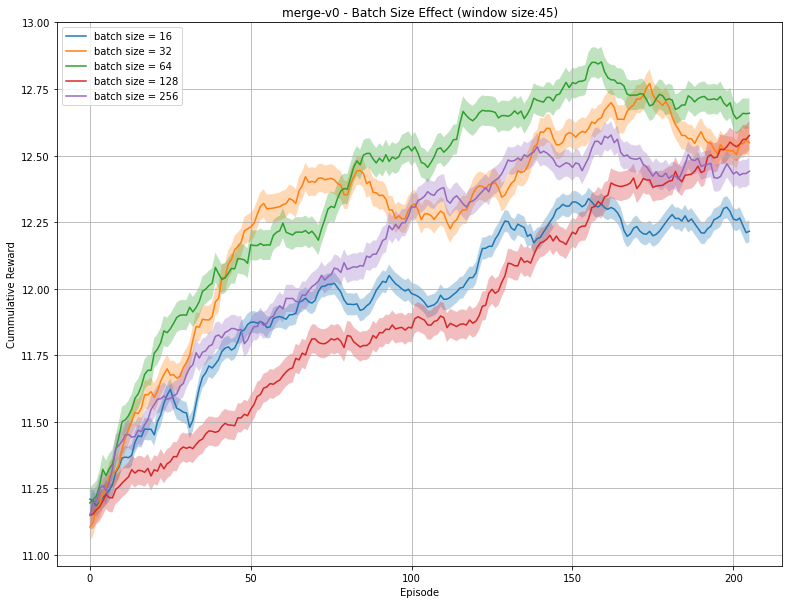

In [ ]:
window_size = 45
cr0_ = np.convolve(np.mean(crs0, axis=0), np.ones(window_size)/window_size, mode='valid')
cr1_ = np.convolve(np.mean(crs1, axis=0), np.ones(window_size)/window_size, mode='valid')
cr2_ = np.convolve(np.mean(crs2, axis=0), np.ones(window_size)/window_size, mode='valid')
cr3_ = np.convolve(np.mean(crs3, axis=0), np.ones(window_size)/window_size, mode='valid')
cr34_ = np.convolve(np.mean(crs34, axis=0), np.ones(window_size)/window_size, mode='valid')
ci0 = 1.96 * np.std(cr0_)/np.sqrt(len(cr0_))
ci1 = 1.96 * np.std(cr1_)/np.sqrt(len(cr1_))
ci2 = 1.96 * np.std(cr2_)/np.sqrt(len(cr2_))
ci3 = 1.96 * np.std(cr3_)/np.sqrt(len(cr3_))
ci34 = 1.96 * np.std(cr34_)/np.sqrt(len(cr34_))

plt.figure(figsize=(13, 10))
plt.title("merge-v0 - Batch Size Effect (window size:"+str(window_size)+")")
plt.plot(cr0_, label='batch size = 16')
plt.plot(cr1_, label='batch size = 32')
plt.plot(cr2_, label='batch size = 64')
plt.plot(cr3_, label='batch size = 128')
plt.plot(cr34_, label='batch size = 256')
plt.fill_between(range(len(cr0_)), (cr0_-ci0), (cr0_+ci0), alpha=.3)
plt.fill_between(range(len(cr1_)), (cr1_-ci1), (cr1_+ci1), alpha=.3)
plt.fill_between(range(len(cr2_)), (cr2_-ci2), (cr2_+ci2), alpha=.3)
plt.fill_between(range(len(cr3_)), (cr3_-ci3), (cr3_+ci3), alpha=.3)
plt.fill_between(range(len(cr34_)), (cr34_-ci34), (cr34_+ci34), alpha=.3)
plt.xlabel("Episode")
plt.ylabel('Cummulative Reward')
plt.legend()
plt.grid()
plt.show()

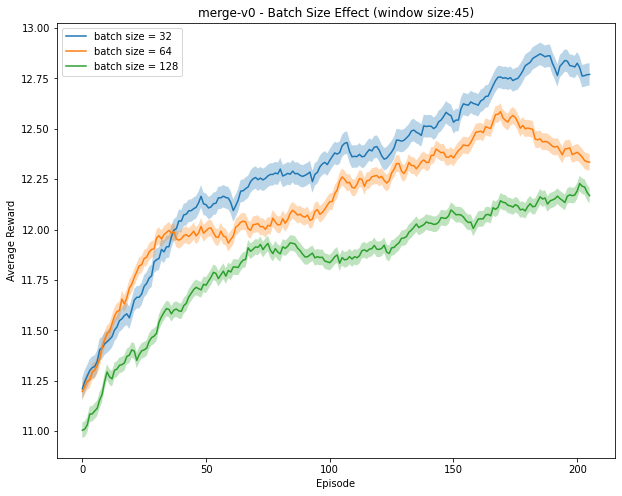

In [ ]:
window_size = 45
cr1_ = np.convolve(np.mean(crs1, axis=0), np.ones(window_size)/window_size, mode='valid')
cr2_ = np.convolve(np.mean(crs2, axis=0), np.ones(window_size)/window_size, mode='valid')
cr3_ = np.convolve(np.mean(crs3, axis=0), np.ones(window_size)/window_size, mode='valid')
ci1 = 1.96 * np.std(cr1_)/np.sqrt(len(cr1_))
ci2 = 1.96 * np.std(cr2_)/np.sqrt(len(cr2_))
ci3 = 1.96 * np.std(cr3_)/np.sqrt(len(cr3_))

plt.figure(figsize=(10, 8))
plt.title("merge-v0 - Batch Size Effect (window size:"+str(window_size)+")")
plt.plot(cr1_, label='batch size = 32')
plt.plot(cr2_, label='batch size = 64')
plt.plot(cr3_, label='batch size = 128')
plt.fill_between(range(len(cr1_)), (cr1_-ci1), (cr1_+ci1), alpha=.3)
plt.fill_between(range(len(cr2_)), (cr2_-ci2), (cr2_+ci2), alpha=.3)
plt.fill_between(range(len(cr3_)), (cr3_-ci3), (cr3_+ci3), alpha=.3)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

<a name='2-3'></a>
## Render

In [ ]:
crs6, agent6  = run_DeepQLearning_agent(_batch_size=32, reps=1)

Episode 25	Average Reward: 7.97	Epsilon: 0.47
Episode 50	Average Reward: 10.86	Epsilon: 0.22
Episode 75	Average Reward: 10.91	Epsilon: 0.10
Episode 100	Average Reward: 10.91	Epsilon: 0.05
Episode 125	Average Reward: 10.94	Epsilon: 0.02
Episode 150	Average Reward: 11.05	Epsilon: 0.01
Episode 175	Average Reward: 14.92	Epsilon: 0.01
Episode 200	Average Reward: 14.92	Epsilon: 0.01
Episode 225	Average Reward: 11.22	Epsilon: 0.01
Episode 250	Average Reward: 14.92	Epsilon: 0.01


In [ ]:
# env = gym.make("highway-v0")
!pip install pygame 
import os
os.environ['SDL_VIDEODRIVER']="x11"
import pygame
pygame.display.set_mode((640,480))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


error: ignored

In [ ]:
if os.environ.get('DISPLAY'):
    print("X11 is available")

In [ ]:
# # from gym.wrappers.monitoring import video_recorder
# # vid = video_recorder.VideoRecorder(env,path="./recording/vid.mp4")
# env = RecordVideo(env, video_folder="run",
#               episode_trigger=lambda e: True)  # record all episodes

# # Provide the video recorder to the wrapped environment
# # so it can send it intermediate simulation frames.
# env.unwrapped.set_record_video_wrapper(env)
done = truncated = False
S, info = env.reset()
while not (done or truncated):
  env.render()
  A = agent6.choose_action(S, 0.1).item()
  obs, reward, done, truncated, info = env.step(A)
  S = obs
env.close()

In [ ]:
!pip install pygame 

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Surface(640x480x32 SW)>

In [ ]:
# from gym.wrappers.monitoring import video_recorder
# vid = video_recorder.VideoRecorder(env,path="./recording/vid.mp4")
env = RecordVideo(env, video_folder="run",
              episode_trigger=lambda e: True)  # record all episodes

# Provide the video recorder to the wrapped environment
# so it can send it intermediate simulation frames.
env.unwrapped.set_record_video_wrapper(env)
done = truncated = False
S, info = env.reset()
while not (done or truncated):
  env.render()
  A = agent6.choose_action(S, 0.2).item()
  obs, reward, done, truncated, info = env.step(A)
  S = obs
env.close()



NameError: ignored

In [ ]:
%load_ext tensorboard
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!git clone https://github.com/eleurent/highway-env.git 2> /dev/null
sys.path.insert(0, '/content/highway-env/scripts/')
from utils import record_videos, show_videos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 9.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
done = truncated = False
S, info = env.reset()
env = record_videos(env)

while not (done or truncated):
  A = agent6.choose_action(S, 0.2).item()
  obs, reward, done, truncated, info = env.step(A)
  S = obs
  env.render(mode='rgb_array')

env.close()
show_videos()

/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <RecordVideo<OrderEnforcing<PassiveEnvChecker<MergeEnv<merge-v0>>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(


In [ ]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
from pathlib import Path
import base64
from tqdm.notebook import trange

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    html = []
    for mp4 in Path("video").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
done = truncated = False
S, info = env.reset()
env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda e: True)
env.unwrapped.set_record_video_wrapper(env)

while not (done or truncated):
  A = agent6.choose_action(S, 0.2).item()
  obs, reward, done, truncated, info = env.step(A)
  S = obs
  

env.close()
show_videos()



/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <RecordVideo<RecordVideo<RecordVideo<OrderEnforcing<PassiveEnvChecker<MergeEnv<merge-v0>>>>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(


In [ ]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

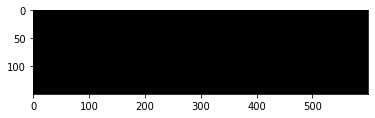

In [ ]:
done = truncated = False
S, info = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
while not (done or truncated):
  A = agent6.choose_action(S, 0.2).item()
  obs, reward, done, truncated, info = env.step(A)
  S = obs
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
ipythondisplay.clear_output(wait=True)
env.close()

<a name='2-4'></a>
## Hyperparameters

In [ ]:
input = keras.layers.Input(shape=(5))
output = keras.layers.Flatten()(input)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dense(5, activation='relu')(output)
model = keras.models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 flatten_1 (Flatten)         (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 512)               3072      
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 530,949
Trainable params: 530,949
Non-trainab

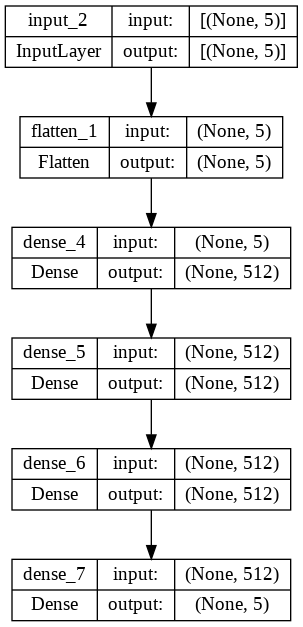

In [ ]:
utils.plot_model(model, show_shapes=True, expand_nested=True)

<a name='3'></a>
# Part 3

In [ ]:
crs1, agent1 = run_DeepQLearning_agent(_batch_size=32, number_of_episodes=400, epsilon_decay_rate=0.98, reps=1)

In [ ]:
env = gym.make("highway-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state_size, action_size 

(5, 5)

In [ ]:
start = time.time()
crs4, agent4 = run_DeepQLearning_agent(_batch_size=32, number_of_episodes=100, epsilon_decay_rate=0.95, reps=3)
end = time.time()

Episode 10	Average Reward: 4.74	Epsilon: 0.60
Episode 20	Average Reward: 1.86	Epsilon: 0.36
Episode 30	Average Reward: 12.77	Epsilon: 0.21
Episode 40	Average Reward: 4.91	Epsilon: 0.13
Episode 50	Average Reward: 28.96	Epsilon: 0.08
Episode 60	Average Reward: 6.02	Epsilon: 0.05
Episode 70	Average Reward: 28.96	Epsilon: 0.03
Episode 80	Average Reward: 29.36	Epsilon: 0.02
Episode 90	Average Reward: 27.58	Epsilon: 0.01
Episode 100	Average Reward: 31.23	Epsilon: 0.01
Episode 10	Average Reward: 25.96	Epsilon: 0.60
Episode 20	Average Reward: 26.10	Epsilon: 0.36
Episode 30	Average Reward: 10.75	Epsilon: 0.21
Episode 40	Average Reward: 25.20	Epsilon: 0.13
Episode 50	Average Reward: 30.24	Epsilon: 0.08
Episode 60	Average Reward: 29.47	Epsilon: 0.05
Episode 70	Average Reward: 8.59	Epsilon: 0.03
Episode 80	Average Reward: 29.36	Epsilon: 0.02
Episode 90	Average Reward: 12.71	Epsilon: 0.01
Episode 100	Average Reward: 11.20	Epsilon: 0.01
Episode 10	Average Reward: 11.77	Epsilon: 0.60
Episode 20	Avera

In [ ]:
print("highway-v0 with random weight learning time: ", (end - start)/60)

highway-v0 with random weight learning time:  70.42721764246623


In [ ]:
print("highway-v0 with random weight learning time: ", (end - start)/60)

highway-v0 with random weight learning time:  68.41666666666667


In [ ]:
start = time.time()
crs5, agent5 = run_DeepQLearning_agent(_batch_size=32, _agent=agent1, number_of_episodes=100, epsilon_decay_rate=0.95, reps=3)
end = time.time()

Episode 10	Average Reward: 11.90	Epsilon: 0.60
Episode 20	Average Reward: 8.31	Epsilon: 0.36
Episode 30	Average Reward: 13.04	Epsilon: 0.21
Episode 40	Average Reward: 27.81	Epsilon: 0.13
Episode 50	Average Reward: 26.96	Epsilon: 0.08
Episode 60	Average Reward: 28.47	Epsilon: 0.05
Episode 70	Average Reward: 26.69	Epsilon: 0.03
Episode 80	Average Reward: 12.77	Epsilon: 0.02
Episode 90	Average Reward: 26.69	Epsilon: 0.01
Episode 100	Average Reward: 2.85	Epsilon: 0.01
Episode 10	Average Reward: 8.00	Epsilon: 0.60
Episode 20	Average Reward: 29.59	Epsilon: 0.36
Episode 30	Average Reward: 27.78	Epsilon: 0.21
Episode 40	Average Reward: 29.76	Epsilon: 0.13
Episode 50	Average Reward: 20.37	Epsilon: 0.08
Episode 60	Average Reward: 28.47	Epsilon: 0.05
Episode 70	Average Reward: 22.51	Epsilon: 0.03
Episode 80	Average Reward: 19.43	Epsilon: 0.02
Episode 90	Average Reward: 29.36	Epsilon: 0.01
Episode 100	Average Reward: 4.31	Epsilon: 0.01
Episode 10	Average Reward: 17.82	Epsilon: 0.60
Episode 20	Aver

In [ ]:
print("highway-v0 with trained weight learning time: ", (end - start)/60)

highway-v0 with trained weight learning time:  67.91883157889048


In [ ]:
print("highway-v0 with trained weight learning time: ", (end - start)/60)

highway-v0 with trained weight learning time:  66.73571458657582


<a name='3-1'></a>
## Result

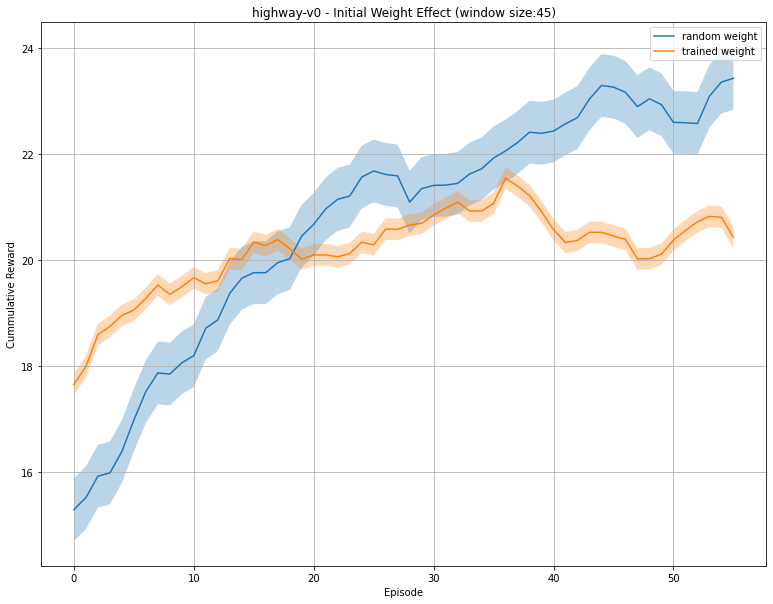

In [ ]:
window_size = 45
cr4_ = np.convolve(np.mean(crs4, axis=0), np.ones(window_size)/window_size, mode='valid')
cr5_ = np.convolve(np.mean(crs5, axis=0), np.ones(window_size)/window_size, mode='valid')
ci4 = 1.96 * np.std(cr4_)/np.sqrt(len(cr4_))
ci5 = 1.96 * np.std(cr5_)/np.sqrt(len(cr5_))

plt.figure(figsize=(13, 10))
plt.title("highway-v0 - Initial Weight Effect (window size:"+str(window_size)+")")
plt.plot(cr4_, label='random weight')
plt.plot(cr5_, label='trained weight')
plt.fill_between(range(len(cr4_)), (cr4_-ci4), (cr4_+ci4), alpha=.3)
plt.fill_between(range(len(cr5_)), (cr5_-ci5), (cr5_+ci5), alpha=.3)
plt.xlabel("Episode")
plt.ylabel('Cummulative Reward')
plt.legend()
plt.grid()
plt.show()

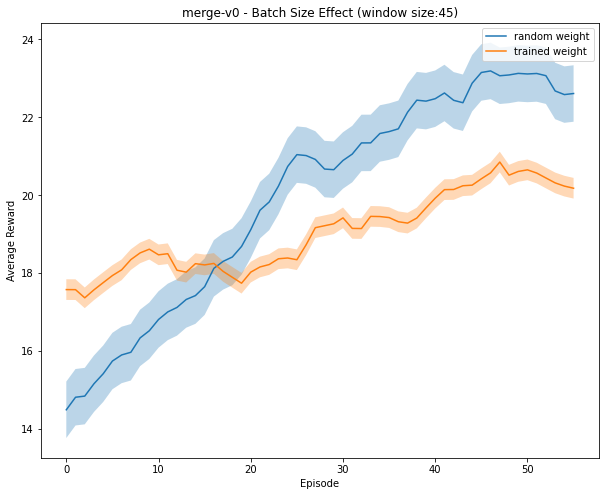

In [ ]:
window_size = 45
cr4_ = np.convolve(np.mean(crs4, axis=0), np.ones(window_size)/window_size, mode='valid')
cr5_ = np.convolve(np.mean(crs5, axis=0), np.ones(window_size)/window_size, mode='valid')
ci4 = 1.96 * np.std(cr4_)/np.sqrt(len(cr4_))
ci5 = 1.96 * np.std(cr5_)/np.sqrt(len(cr5_))

plt.figure(figsize=(10, 8))
plt.title("merge-v0 - Batch Size Effect (window size:"+str(window_size)+")")
plt.plot(cr4_, label='random weight')
plt.plot(cr5_, label='trained weight')
plt.fill_between(range(len(cr4_)), (cr4_-ci4), (cr4_+ci4), alpha=.3)
plt.fill_between(range(len(cr5_)), (cr5_-ci5), (cr5_+ci5), alpha=.3)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

<a name='4'></a>
# Part 4

<a name='4-1'></a>
## DQN with Prioritized Replay Buffer

In [ ]:
class SumTree:
    def __init__(self, size):
        self.nodes = [0] * (2 * size - 1)
        self.data = [None] * size
        self.size = size
        self.count = 0
        self.real_size = 0

    @property
    def total(self):
        return self.nodes[0]

    def update(self, data_idx, value):
        idx = data_idx + self.size - 1  
        change = value - self.nodes[idx]
        self.nodes[idx] = value
        parent = (idx - 1) // 2
        while parent >= 0:
            self.nodes[parent] += change
            parent = (parent - 1) // 2

    def add(self, value, data):
        self.data[self.count] = data
        self.update(self.count, value)
        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)

    def get(self, cumsum):
        assert cumsum <= self.total
        idx = 0
        while 2 * idx + 1 < len(self.nodes):
            left, right = 2*idx + 1, 2*idx + 2
            if cumsum <= self.nodes[left]:
                idx = left
            else:
                idx = right
                cumsum = cumsum - self.nodes[left]
        data_idx = idx - self.size + 1
        return data_idx, self.nodes[idx], self.data[data_idx]

    def __repr__(self):
        return f"SumTree(nodes={self.nodes.__repr__()}, data={self.data.__repr__()})"

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, state_size, action_size, buffer_size, eps=1e-2, alpha=0.1, beta=0.1):
        self.tree = SumTree(size=buffer_size)
        self.eps = eps  
        self.alpha = alpha  
        self.beta = beta  
        self.max_priority = eps 
        self.state = torch.empty(buffer_size, state_size, action_size, dtype=torch.float)
        self.action = torch.empty(buffer_size, action_size, dtype=torch.float)
        self.reward = torch.empty(buffer_size, dtype=torch.float)
        self.next_state = torch.empty(buffer_size, state_size, action_size, dtype=torch.float)
        self.done = torch.empty(buffer_size, dtype=torch.int)
        self.count = 0
        self.real_size = 0
        self.size = buffer_size

    def add(self, transition):
        state, action, reward, next_state, done = transition
        self.tree.add(self.max_priority, self.count)
        # print(len(self.state[self.count]), len(state), len(state[0]))
        self.state[self.count] = torch.as_tensor(state).to(device)
        self.action[self.count] = torch.as_tensor(action).to(device)
        self.reward[self.count] = torch.as_tensor(reward).to(device)
        self.next_state[self.count] = torch.as_tensor(next_state).to(device)
        self.done[self.count] = torch.as_tensor(done).to(device)

        # self.state[self.count] = torch.from_numpy(np.vstack(state)).float()
        # self.action[self.count] = torch.tensor(np.vstack(action)).long()
        # self.reward[self.count] = torch.tensor(np.vstack(reward)).float()
        # self.next_state[self.count] = torch.from_numpy(np.vstack(next_state)).float()
        # self.done[self.count] = torch.tensor(np.vstack(done))

        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)

    def sample(self, batch_size):
        assert self.real_size >= batch_size, "buffer contains less samples than batch size"

        sample_idxs, tree_idxs = [], []
        priorities = torch.empty(batch_size, 1, dtype=torch.float)

        segment = self.tree.total / batch_size
        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)

            cumsum = random.uniform(a, b)

            tree_idx, priority, sample_idx = self.tree.get(cumsum)

            priorities[i] = priority
            tree_idxs.append(tree_idx)
            sample_idxs.append(sample_idx)

        probs = priorities / self.tree.total

        weights = (self.real_size * probs) ** -self.beta

        weights = weights / weights.max()

        batch = (
            self.state[sample_idxs].to(device),
            self.action[sample_idxs].to(device),
            self.reward[sample_idxs].to(device),
            self.next_state[sample_idxs].to(device),
            self.done[sample_idxs].to(device)
        )
        return batch, weights, tree_idxs

    def update_priorities(self, data_idxs, priorities):
        if isinstance(priorities, torch.Tensor):
            priorities = priorities.detach().cpu().numpy()

        for data_idx, priority in zip(data_idxs, priorities):
            priority = (priority + self.eps) ** self.alpha

            self.tree.update(data_idx, priority)
            self.max_priority = max(self.max_priority, priority)

In [ ]:
class DQN_PER:
    def __init__(self, state_size, action_size, gamma, tau, lr):
        # self.model = nn.Sequential(
        #     nn.Linear(state_size, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, action_size)
        # ).to(device)
        # self.target_model = deepcopy(self.model).to(device)
        self.model = DQN(state_size, action_size).to(device)
        self.target_model = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.tau = tau
        self.action_size = action_size

    def soft_update(self, target, source):
        for tp, sp in zip(target.parameters(), source.parameters()):
            tp.data.copy_((1 - self.tau) * tp.data + self.tau * sp.data)

    def act(self, state):
        with torch.no_grad():
            # state = torch.as_tensor(state, dtype=torch.float)
            state = torch.from_numpy(state).float().to(device)
            action = torch.argmax(self.model(state)).cpu().numpy().item() % action_size
            # print(len(self.model(state)))
            # action = torch.argmax(self.model(state)).view(1, 1)  % action_size
        return action

    def update(self, batch, _action, weights=None):
        state, action, reward, next_state, done = batch
        Q_next = self.target_model(next_state).max(dim=1).values
        # print(len(done[0]), len(reward[0]), len(Q_next[0]))
        # print(reward)
        # print(done)
        # print(Q_next)
        Q_next = Q_next[:,_action]
        Q_target = reward + self.gamma * (1 - done) * Q_next
        # print(len(self.model(state)))        [torch.arange(len(action)), action.to(torch.long).flatten()]
        Q = self.model(state)
        # assert Q.shape == Q_target.shape, f"{Q.shape}, {Q_target.shape}"

        if weights is None:
            weights = torch.ones_like(Q)
        # print(len(Q[0]))
        Q = Q[:,_action][:,_action].to(device)
        # Q = Q[:,0][:,0].to(device)
        weights=weights.to(device)
        Q_target = Q_target.to(device)
        td_error = torch.abs(Q - Q_target).detach()
        # loss = torch.mean((Q - Q_target)**2 * weights)

        loss = F.mse_loss(Q, Q_target).squeeze() * weights
        loss = loss.mean()
        # loss = F.mse_loss((Q - Q_target)**2 * weights).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        with torch.no_grad():
            self.soft_update(self.target_model, self.model)
        return loss.item(), td_error

    def save(self):
        torch.save(self.model, "agent.pkl")

In [ ]:
def evaluate_policy(env_name, agent, episodes=5, seed=0):

    returns = []
    for _ in range(episodes):
        state,_ = env.reset()
        done = truncated = False
        total_reward = 0
        while not (done or truncated):
            
            next_state, reward, done, truncated, info = env.step(agent.act(state))
            total_reward += reward
            state = next_state
        returns.append(total_reward)
    return np.mean(returns), np.std(returns)

In [ ]:
def train(env_name, model, buffer, timesteps=200_000, batch_size=128,
          eps_max=0.1, eps_min=0.0, test_every=5000, seed=0):

    rewards_total, stds_total = [], []
    loss_count, total_loss = 0, 0

    episodes = 0
    best_reward = -np.inf

    state,_ = env.reset()
    done = truncated = False

    for step in range(1, timesteps + 1):
        if done:
            state,_ = env.reset()
            done = truncated = False
            episodes += 1

        eps = eps_max - (eps_max - eps_min) * step / timesteps

        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = model.act(state)

        next_state, reward, done, truncated, info = env.step(action)
        buffer.add((state, action, reward, next_state, int(done)))

        state = next_state

        if step > batch_size:

            batch, weights, tree_idxs = buffer.sample(batch_size)
            loss, td_error = model.update(batch, action, weights=weights)

            buffer.update_priorities(tree_idxs, td_error.cpu().numpy())

            total_loss += loss
            loss_count += 1

            if step % test_every == 0:
                mean, std = evaluate_policy(env_name, model, episodes=10, seed=seed)

                print(f"Episode: {episodes}, Step: {step}, Reward mean: {mean:.2f}, Reward std: {std:.2f}, Loss: {total_loss / loss_count:.4f}, Eps: {eps}")

                if mean > best_reward:
                    best_reward = mean
                    model.save()

                rewards_total.append(mean)
                stds_total.append(std)

    return np.array(rewards_total), np.array(stds_total)

In [ ]:
def run_experiment(config, use_priority=False, n_seeds=10):
    torch.manual_seed(0)
    mean_rewards = []

    for seed in range(n_seeds):
        buffer = PrioritizedReplayBuffer(**config["buffer"])

        model = DQN_PER(**config["model"])

        seed_reward, seed_std = train(seed=seed, model=model, buffer=buffer, **config["train"])
        mean_rewards.append(seed_reward)

    mean_rewards = np.array(mean_rewards)

    return mean_rewards, mean_rewards.mean(axis=0), mean_rewards.std(axis=0)

<a name='4-2'></a>
## Reward

In [ ]:
config = {
    
    "buffer": {
        "state_size": 5,
        "action_size": 5,  # action is discrete
        "buffer_size": 50_000
    },
    "model": {
        "state_size": 5,
        "action_size": 5,
        "gamma": 0.99,
        "lr": 1e-4,
        "tau": 0.01
    },
    "train": {
        "env_name": "merge-v0",
        "timesteps": 100,
        "batch_size": 32,
        "test_every": 5,
        "eps_max": 0.99,
        "eps_min": 0.01
    }
}


priority_config = deepcopy(config)
priority_config["buffer"].update({"alpha": 0.7, "beta": 0.4})

In [ ]:
mpr, mean_priority_reward, std_priority_reward = run_experiment(priority_config)

Episode: 2, Step: 35, Reward mean: 10.75, Reward std: 0.00, Loss: 0.4971, Eps: 0.647
Episode: 3, Step: 40, Reward mean: 10.75, Reward std: 0.00, Loss: 0.3800, Eps: 0.598
Episode: 4, Step: 45, Reward mean: 10.75, Reward std: 0.00, Loss: 0.3340, Eps: 0.5489999999999999
Episode: 5, Step: 50, Reward mean: 10.75, Reward std: 0.00, Loss: 0.3190, Eps: 0.5
Episode: 6, Step: 55, Reward mean: 10.75, Reward std: 0.00, Loss: 0.2609, Eps: 0.45099999999999996
Episode: 7, Step: 60, Reward mean: 10.75, Reward std: 0.00, Loss: 0.2299, Eps: 0.402
Episode: 8, Step: 65, Reward mean: 10.75, Reward std: 0.00, Loss: 0.2162, Eps: 0.353
Episode: 9, Step: 70, Reward mean: 10.75, Reward std: 0.00, Loss: 0.1946, Eps: 0.30400000000000005
Episode: 10, Step: 75, Reward mean: 10.75, Reward std: 0.00, Loss: 0.1873, Eps: 0.255
Episode: 11, Step: 80, Reward mean: 10.75, Reward std: 0.00, Loss: 0.1770, Eps: 0.20599999999999996
Episode: 12, Step: 85, Reward mean: 10.75, Reward std: 0.00, Loss: 0.1645, Eps: 0.1570000000000

In [ ]:
mean_priority_reward

array([11.28700539, 11.33081553, 11.33081553, 11.33081553, 11.33081553,
       11.33081553, 11.33081553, 11.33081553, 11.33081553, 11.33081553,
       11.33081553, 11.33081553, 11.33081553, 11.33081553])

In [ ]:
mpr, mean_priority_reward, std_priority_reward = run_experiment(priority_config)

Episode: 2, Step: 33, Reward mean: 10.75, Reward std: 0.00, Loss: 0.9141, Eps: 0.6666000000000001
Episode: 2, Step: 34, Reward mean: 10.75, Reward std: 0.00, Loss: 0.8443, Eps: 0.6568
Episode: 3, Step: 35, Reward mean: 10.89, Reward std: 0.00, Loss: 0.7984, Eps: 0.647
Episode: 3, Step: 36, Reward mean: 10.47, Reward std: 0.00, Loss: 0.7667, Eps: 0.6372
Episode: 4, Step: 37, Reward mean: 10.58, Reward std: 0.00, Loss: 0.7405, Eps: 0.6274
Episode: 4, Step: 38, Reward mean: 10.75, Reward std: 0.00, Loss: 0.7295, Eps: 0.6175999999999999
Episode: 5, Step: 39, Reward mean: 10.58, Reward std: 0.00, Loss: 0.7152, Eps: 0.6078
Episode: 5, Step: 40, Reward mean: 10.58, Reward std: 0.00, Loss: 0.7347, Eps: 0.598
Episode: 6, Step: 41, Reward mean: 10.58, Reward std: 0.00, Loss: 0.7117, Eps: 0.5882000000000001
Episode: 6, Step: 42, Reward mean: 10.75, Reward std: 0.00, Loss: 0.6946, Eps: 0.5784
Episode: 7, Step: 43, Reward mean: 10.75, Reward std: 0.00, Loss: 0.6798, Eps: 0.5686
Episode: 7, Step: 44

array([[10.74707855, 10.74707855, 10.89309312, 10.46930077, 10.58041188,
        10.74707855, 10.58041188, 10.58041188, 10.58041188, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855, 10.74707855, 10.74707855,
        10.74707855, 10.74707855, 10.74707855],
   

In [ ]:
mpr, mean_priority_reward, std_priority_reward = run_experiment(priority_config)

Episode: 2, Step: 35, Reward mean: 10.75, Reward std: 0.00, Loss: 0.7092, Eps: 0.8528
Episode: 3, Step: 40, Reward mean: 10.75, Reward std: 0.00, Loss: 0.6637, Eps: 0.8331999999999999
Episode: 4, Step: 45, Reward mean: 10.75, Reward std: 0.00, Loss: 0.6140, Eps: 0.8136
Episode: 5, Step: 50, Reward mean: 10.75, Reward std: 0.00, Loss: 0.5955, Eps: 0.794
Episode: 6, Step: 55, Reward mean: 10.75, Reward std: 0.00, Loss: 0.5527, Eps: 0.7744
Episode: 7, Step: 60, Reward mean: 10.75, Reward std: 0.00, Loss: 0.4744, Eps: 0.7548
Episode: 8, Step: 65, Reward mean: 10.75, Reward std: 0.00, Loss: 0.4989, Eps: 0.7352000000000001
Episode: 9, Step: 70, Reward mean: 10.75, Reward std: 0.00, Loss: 0.4786, Eps: 0.7156
Episode: 10, Step: 75, Reward mean: 10.75, Reward std: 0.00, Loss: 0.4466, Eps: 0.696
Episode: 11, Step: 80, Reward mean: 10.75, Reward std: 0.00, Loss: 0.4170, Eps: 0.6763999999999999
Episode: 12, Step: 85, Reward mean: 10.75, Reward std: 0.00, Loss: 0.3924, Eps: 0.6568
Episode: 13, Step

In [ ]:
mean_reward, agent1 = run_DeepQLearning_agent(_batch_size=32, reps = 1)

Episode 25	Average Reward: 11.00	Epsilon: 0.47
Episode 50	Average Reward: 13.72	Epsilon: 0.22
Episode 75	Average Reward: 13.53	Epsilon: 0.10
Episode 100	Average Reward: 13.25	Epsilon: 0.05
Episode 125	Average Reward: 14.97	Epsilon: 0.02
Episode 150	Average Reward: 14.33	Epsilon: 0.01
Episode 175	Average Reward: 10.75	Epsilon: 0.01
Episode 200	Average Reward: 14.92	Epsilon: 0.01
Episode 225	Average Reward: 11.08	Epsilon: 0.01
Episode 250	Average Reward: 14.92	Epsilon: 0.01


In [ ]:
mean_priority_reward

array([11.33081553, 10.13909417, 11.2974822 , 11.2974822 , 11.26137109,
       10.88061371, 10.88061371, 10.88061371, 10.88061371, 10.88061371,
       10.88061371, 10.88061371, 10.88061371, 10.88061371, 11.2174606 ,
       11.30879514, 11.35899697, 11.74788586, 11.77010808, 11.8778844 ,
       12.56177475, 12.99808768, 12.98697657, 12.98995618, 12.99551173,
       12.54831833, 12.18899551, 11.81117232, 12.19470748, 12.14183845,
       12.5423303 , 12.19718383, 11.85823813, 11.8084483 , 11.8778844 ,
       11.50344141, 11.90086546, 11.85581859, 10.96999657, 11.7673303 ,
       11.7673303 , 11.36414887, 11.36414887, 11.36414887])

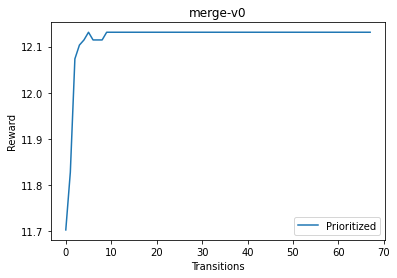

In [ ]:
steps = np.arange(mean_priority_reward.shape[0]) * config["train"]["test_every"]

# mean_reward_ = np.convolve(np.mean(mean_reward, axis=0), np.ones(window_size)/window_size, mode='valid')
# mean_reward_ = np.mean(mean_reward, axis=0)
# ci1 = 1.96 * np.std(mean_reward_)/np.sqrt(len(mean_reward_))

# plt.plot(steps, mean_reward_, label="Normal")
# plt.fill_between(steps, mean_reward - std_reward, mean_reward + std_reward, alpha=0.3)
plt.plot(steps, mean_priority_reward, label="Prioritized")
# plt.fill_between(steps, mean_priority_reward - std_priority_reward, mean_priority_reward + std_priority_reward, alpha=0.3)

plt.legend()
plt.title(config["train"]["env_name"])
plt.xlabel("Transitions")
plt.ylabel("Reward")
plt.savefig(f"{config['train']['env_name']}.jpg", dpi=200, bbox_inches='tight')